In [1]:
import os
import gc
import sys
import torch
import psutil
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, set_image_backend

import data_utils
import train_utils

%reload_ext autoreload
%autoreload 2

set_image_backend('accimage')

In [2]:
def forward_pass(e, dataset, encoding, valid_loader, resnet, criterion):
    total_loss = 0
    all_labels = []
    all_preds = []
    all_loss = []
    all_probs = []

    for idx,(batch,labels) in enumerate(valid_loader):
        batch, labels = batch.cuda(device=device), encoding[labels.cuda(device=device)]
        output = resnet(batch)
        loss = criterion(output, labels)

        total_loss += torch.sum(loss.detach().mean(dim=1)).cpu().numpy()
        all_labels.extend(torch.sum(labels, dim=1).float().cpu().numpy())
        all_preds.extend(torch.sum(torch.sigmoid(output) > 0.5, dim=1).float().detach().cpu().numpy())
        all_loss.extend(loss.detach().mean(dim=1).cpu().numpy())
        all_probs.extend(torch.mean(torch.sigmoid(output), dim=1).float().detach().cpu().numpy())

        if idx % 100 == 0:
            print('Epoch: {0}, Batch: {1}, {3} NLL: {2:0.4f}'.format(e, idx, torch.sum(loss.detach())/batch.shape[0], dataset))

    return idx, total_loss, all_labels, all_preds, all_loss, all_probs

In [3]:
def print_results(e, idx, dataset, batch_size, total_loss, all_labels, all_preds, all_loss, jpg_to_sample, encoding):
    acc = np.mean(np.array(all_labels) == np.array(all_preds))

    d = {'label': all_labels, 'pred': all_preds, 'sample': jpg_to_sample}
    df = pd.DataFrame(data = d)
    df['correct_tile'] = df['label'] == df['pred']    
    tile_acc_by_label = ', '.join([str(i) + ': ' + str(float(df.groupby(['label'])['correct_tile'].mean()[i]))[:6] for i in range(encoding.shape[0])])

    df2 = df.groupby(['sample'])['label','pred'].mean().round()
    df2['correct_sample'] = df2['label'] == df2['pred']
    mean_pool_acc = df2['correct_sample'].mean()

    df3 = df.groupby(['sample'])['label','pred'].max()
    df3['correct_sample'] = df3['label'] == df3['pred']
    max_pool_acc = df3['correct_sample'].mean()

    slide_acc_by_label = ', '.join([str(i) + ': ' + str(float(df2.groupby(['label'])['correct_sample'].mean()[i]))[:6] for i in range(encoding.shape[0])])

    print('Epoch: {0}, Avg {3} NLL: {1:0.4f}, Median {3} NLL: {2:0.4f}'.format(e, total_loss/(float(idx+1) * batch_size), 
                                                                               np.median(all_loss), dataset))
    print('------ {2} Tile-Level Acc: {0:0.4f}; By Label: {1}'.format(acc, tile_acc_by_label, dataset))
    print('------ {2} Slide-Level Acc: Mean-Pooling: {0:0.4f}, Max-Pooling: {1:0.4f}'.format(mean_pool_acc, max_pool_acc, 
                                                                                             dataset))
    print('------ {1} Slide-Level Acc (Mean-Pooling) By Label: {0}'.format(slide_acc_by_label, dataset))
    
    return df

In [4]:
def print_roc_curves(task, level, labels=None, probs=None, df=None):
    if level == 'Slide':
        slide_df = df.groupby(['sample'])['label','pred'].mean()
        labels = slide_df['label']
        probs = slide_df['pred']
        
    fpr, tpr, thresholds = metrics.roc_curve(np.array(labels), np.array(probs))
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=level + '-level' + 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (' + task + ')')
    plt.legend(loc="lower right")
    plt.show()

In [56]:
def get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, 
                           batch_size, n_workers, output_shape, criterion, device, magnification, printer='on'):
    #with open(pickle_file, 'rb') as f: 
    _, sa_val = data_utils.load_COAD_train_val_sa_pickle(pickle_file)
    val_set = data_utils.TCGADataset_tiles(sa_val, root_dir, transform=transform, magnification=magnification)
    jpg_to_sample = val_set.jpg_to_sample
    valid_loader = DataLoader(val_set, batch_size=batch_size, pin_memory=True, num_workers=n_workers)

    resnet = models.resnet18(pretrained=True)
    resnet.fc = nn.Linear(2048, output_shape, bias=True)
    saved_state = torch.load(state_dict_file, map_location=lambda storage, loc: storage)
    resnet.load_state_dict(saved_state)
    resnet.cuda(device=device)
    resnet.eval()

    for param in resnet.parameters():
        param.requires_grad = False

    if task == 'MSI':
        encoding = torch.tensor([[0,0],[1,0],[1,1]], device=device).float()
    elif task == 'WGD' or task == 'MSI-SINGLE_LABEL':
        encoding = torch.tensor([[0],[1]], device=device).float()

    idx, total_loss, all_labels, all_preds, all_loss, all_probs = forward_pass(e, dataset, encoding, valid_loader, resnet, criterion)
    df = print_results(e, idx, dataset, batch_size, total_loss, all_labels, all_preds, all_loss, jpg_to_sample, encoding)
    if printer == 'on':
        print_roc_curves(task, 'Tile', labels=all_labels, probs=all_probs)
        print_roc_curves(task, 'Slide', df=df) 
    else:
        return all_labels, all_probs, df

In [57]:
def print_all_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, batch_size, n_workers, 
                     output_shape, criterion, device, magnification, file_name=None):
    all_labels, all_probs, df = get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, 
                                                       transform, batch_size, n_workers, output_shape, criterion, 
                                                       device, magnification, printer='off')   
    fig = plt.figure()
    lw = 2
    # tile curve
    fpr, tpr, thresholds = metrics.roc_curve(np.array(all_labels), np.array(all_probs))
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Tile-level ROC curve (area = %0.2f)' % roc_auc)
    # slide curve
    slide_df = df.groupby(['sample'])['label','pred'].mean()
    labels = slide_df['label']
    probs = slide_df['pred']
    fpr, tpr, thresholds = metrics.roc_curve(np.array(labels), np.array(probs))
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkred', lw=lw, label='Slide-level ROC curve (area = %0.2f)' % roc_auc)
    # general
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ResNet18 (COAD {0} {1}x)'.format(task[:3], magnification))
    plt.legend(loc="lower right")
    plt.show()
    fig.set_dpi(300)
    fig.savefig(file_name)

In [58]:
e = 0
dataset = 'Val'
root_dir = '/n/mounted-data-drive/COAD/'
transform = train_utils.transform_validation
batch_size = 256
n_workers = 12
output_shape = 1
criterion = nn.BCEWithLogitsLoss(reduction = 'none')
device = torch.device('cuda', 1)

## Combined plots for tile-level and slide-level

Epoch: 0, Batch: 0, Val NLL: 0.6787
Epoch: 0, Batch: 100, Val NLL: 1.1857
Epoch: 0, Batch: 200, Val NLL: 0.9087
Epoch: 0, Avg Val NLL: 0.7208, Median Val NLL: 0.5728
------ Val Tile-Level Acc: 0.5939; By Label: 0: 0.6353, 1: 0.5115
------ Val Slide-Level Acc: Mean-Pooling: 0.6585, Max-Pooling: 0.3537
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.7358, 1: 0.5172


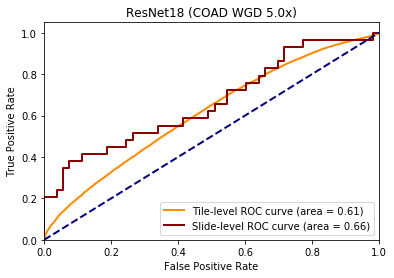

Epoch: 0, Batch: 0, Val NLL: 0.6798
Epoch: 0, Batch: 100, Val NLL: 0.7712
Epoch: 0, Batch: 200, Val NLL: 0.5383
Epoch: 0, Batch: 300, Val NLL: 0.5689
Epoch: 0, Batch: 400, Val NLL: 0.6420
Epoch: 0, Batch: 500, Val NLL: 0.7508
Epoch: 0, Batch: 600, Val NLL: 0.6796
Epoch: 0, Batch: 700, Val NLL: 0.5699
Epoch: 0, Batch: 800, Val NLL: 0.3643
Epoch: 0, Avg Val NLL: 0.7209, Median Val NLL: 0.5967
------ Val Tile-Level Acc: 0.5797; By Label: 0: 0.5894, 1: 0.5646
------ Val Slide-Level Acc: Mean-Pooling: 0.6951, Max-Pooling: 0.4390
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.6956, 1: 0.6944


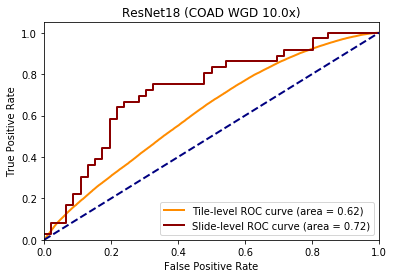

In [38]:
task = 'WGD'
pickle_files = ['/n/tcga_models/resnet18_WGD_v04_sa.pkl', '/n/tcga_models/resnet18_WGD_10x_sa.pkl']
state_dict_files = ['/n/tcga_models/resnet18_WGD_v04.pt', '/n/tcga_models/resnet18_WGD_10x.pt']
print_all_curves(e, dataset, task, pickle_files[0], state_dict_files[0], root_dir, transform, batch_size, 
                 n_workers, output_shape, criterion, device, '5.0', file_name='resnet18_WGD_5x_roc.png')
print_all_curves(e, dataset, task, pickle_files[1], state_dict_files[1], root_dir, transform, batch_size, 
                 n_workers, output_shape, criterion, device, '10.0', file_name='resnet18_WGD_10x_roc.png')

Epoch: 0, Batch: 0, Val NLL: 2.0527
Epoch: 0, Batch: 100, Val NLL: 1.0325
Epoch: 0, Avg Val NLL: 0.8339, Median Val NLL: 0.6193
------ Val Tile-Level Acc: 0.5491; By Label: 0: 0.6631, 1: 0.3921
------ Val Slide-Level Acc: Mean-Pooling: 0.5972, Max-Pooling: 0.4306
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.8048, 1: 0.3225


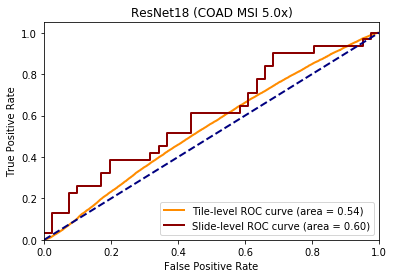

Epoch: 0, Batch: 0, Val NLL: 1.3158
Epoch: 0, Batch: 100, Val NLL: 0.1545
Epoch: 0, Batch: 200, Val NLL: 0.8611
Epoch: 0, Batch: 300, Val NLL: 0.6735
Epoch: 0, Batch: 400, Val NLL: 0.5420
Epoch: 0, Batch: 500, Val NLL: 1.2138
Epoch: 0, Batch: 600, Val NLL: 0.7641
Epoch: 0, Batch: 700, Val NLL: 1.6394
Epoch: 0, Avg Val NLL: 0.9128, Median Val NLL: 0.6707
------ Val Tile-Level Acc: 0.5146; By Label: 0: 0.5524, 1: 0.4608
------ Val Slide-Level Acc: Mean-Pooling: 0.6056, Max-Pooling: 0.4507
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.6923, 1: 0.5


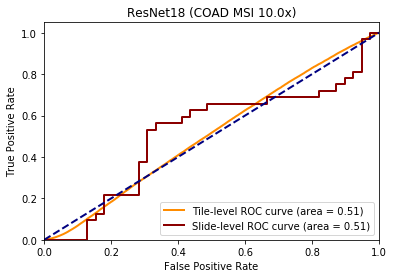

In [59]:
task = 'MSI-SINGLE_LABEL'
pickle_files = ['/n/tcga_models/archive/resnet18_MSI_singlelabel_v02_sa.pkl', '/n/tcga_models/archive/resnet18_MSI_singlelabel_10x_sa.pkl']
state_dict_files = ['/n/tcga_models/archive/resnet18_MSI_singlelabel_v02.pt', '/n/tcga_models/archive/resnet18_MSI_singlelabel_10x.pt']
print_all_curves(e, dataset, task, pickle_files[0], state_dict_files[0], root_dir, transform, batch_size, 
                 n_workers, output_shape, criterion, device, '5.0', file_name='resnet18_MSI_5x_roc.png')
print_all_curves(e, dataset, task, pickle_files[1], state_dict_files[1], root_dir, transform, batch_size, 
                 n_workers, output_shape, criterion, device, '10.0', file_name='resnet18_MSI_10x_roc.png')

## Separate plots for tile-level and slide-level

In [13]:
task = 'WGD'
pickle_file = '/n/tcga_models/resnet18_WGD_v04_sa.pkl'
state_dict_file = '/n/tcga_models/resnet18_WGD_v04.pt'
magnification = '5.0'

Epoch: 0, Batch: 0, Val NLL: 0.6787
Epoch: 0, Batch: 100, Val NLL: 1.1857
Epoch: 0, Batch: 200, Val NLL: 0.9087
Epoch: 0, Avg Val NLL: 0.7208, Median Val NLL: 0.5728
------ Val Tile-Level Acc: 0.5939; By Label: 0: 0.6353, 1: 0.5115
------ Val Slide-Level Acc: Mean-Pooling: 0.6585, Max-Pooling: 0.3537
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.7358, 1: 0.5172


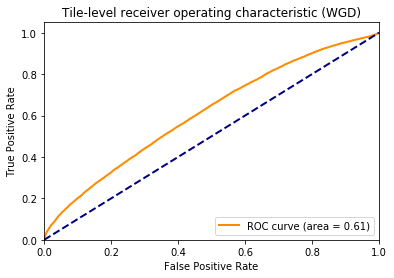

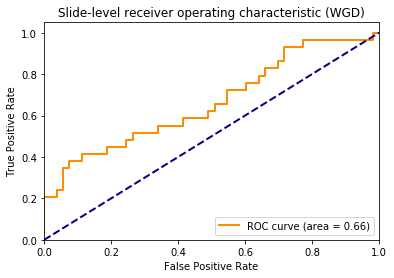

In [14]:
get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, 
                       batch_size, n_workers, output_shape, criterion, device, magnification)

In [11]:
task = 'MSI-SINGLE_LABEL'
pickle_file = '/n/tcga_models/resnet18_MSI_singlelabel_v02_sa.pkl'
state_dict_file = '/n/tcga_models/resnet18_MSI_singlelabel_v02.pt'
magnification = '5.0'

Epoch: 0, Batch: 0, Val NLL: 2.0527
Epoch: 0, Batch: 100, Val NLL: 1.0325
Epoch: 0, Avg Val NLL: 0.8339, Median Val NLL: 0.6193
------ Val Tile-Level Acc: 0.5491; By Label: 0: 0.6631, 1: 0.3921
------ Val Slide-Level Acc: Mean-Pooling: 0.5972, Max-Pooling: 0.4306
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.8048, 1: 0.3225


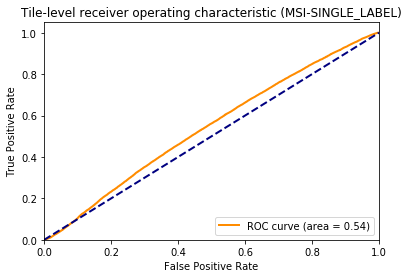

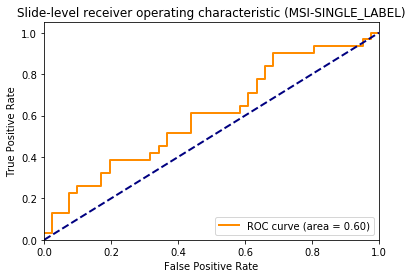

In [12]:
get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, 
                       batch_size, n_workers, output_shape, criterion, device, magnification)

In [7]:
task = 'WGD'
pickle_file = '/n/tcga_models/resnet18_WGD_10x_sa.pkl'
state_dict_file = '/n/tcga_models/resnet18_WGD_10x.pt'
magnification = '10.0'

Epoch: 0, Batch: 0, Val NLL: 0.6798
Epoch: 0, Batch: 100, Val NLL: 0.7712
Epoch: 0, Batch: 200, Val NLL: 0.5383
Epoch: 0, Batch: 300, Val NLL: 0.5689
Epoch: 0, Batch: 400, Val NLL: 0.6420
Epoch: 0, Batch: 500, Val NLL: 0.7508
Epoch: 0, Batch: 600, Val NLL: 0.6796
Epoch: 0, Batch: 700, Val NLL: 0.5699
Epoch: 0, Batch: 800, Val NLL: 0.3643
Epoch: 0, Avg Val NLL: 0.7209, Median Val NLL: 0.5967
------ Val Tile-Level Acc: 0.5797; By Label: 0: 0.5894, 1: 0.5646
------ Val Slide-Level Acc: Mean-Pooling: 0.6951, Max-Pooling: 0.4390
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.6956, 1: 0.6944


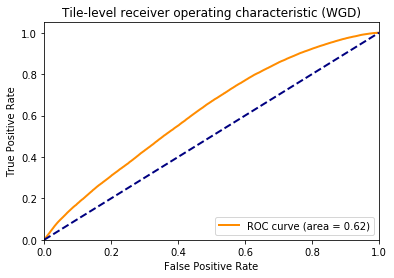

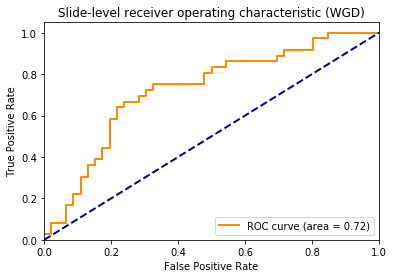

In [8]:
get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, 
                       batch_size, n_workers, output_shape, criterion, device, magnification)

In [9]:
task = 'MSI-SINGLE_LABEL'
pickle_file = '/n/tcga_models/resnet18_MSI_singlelabel_10x_sa.pkl'
state_dict_file = '/n/tcga_models/resnet18_MSI_singlelabel_10x.pt'
magnification = '10.0'

Epoch: 0, Batch: 0, Val NLL: 1.3158
Epoch: 0, Batch: 100, Val NLL: 0.1545
Epoch: 0, Batch: 200, Val NLL: 0.8537
Epoch: 0, Batch: 300, Val NLL: 0.6761
Epoch: 0, Batch: 400, Val NLL: 0.5430
Epoch: 0, Batch: 500, Val NLL: 1.2154
Epoch: 0, Batch: 600, Val NLL: 0.7672
Epoch: 0, Batch: 700, Val NLL: 1.6377
Epoch: 0, Avg Val NLL: 0.9128, Median Val NLL: 0.6707
------ Val Tile-Level Acc: 0.5146; By Label: 0: 0.5524, 1: 0.4608
------ Val Slide-Level Acc: Mean-Pooling: 0.6111, Max-Pooling: 0.4583
------ Val Slide-Level Acc (Mean-Pooling) By Label: 0: 0.7, 1: 0.5


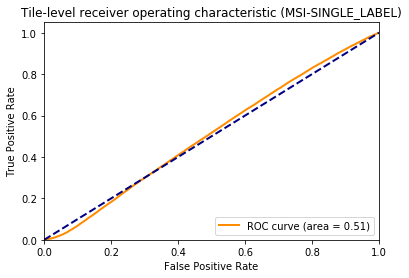

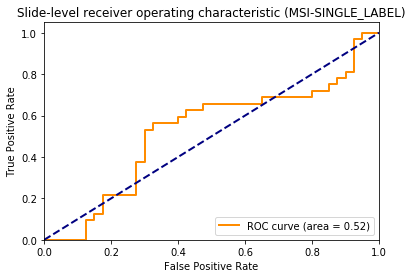

In [10]:
get_results_and_curves(e, dataset, task, pickle_file, state_dict_file, root_dir, transform, 
                       batch_size, n_workers, output_shape, criterion, device, magnification)